In [1]:
from fastai.vision.all import *
import fastai
import timm
from wwf.vision.timm import *
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(0)

In [3]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [4]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [5]:
np.unique(df['management'])

array(['conv', 'eco'], dtype=object)

In [6]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [7]:
dftrain.columns

Index(['Unnamed: 0', 'file', 'DAS', 'plot nº', 'photo nº', 'species',
       'water_treatment', 'management', 'plot m2', 'avg_water (L m-2)',
       'N (kg microplot-1)', 'P (kg microplot-1)', 'K (kg microplot-1)',
       'avg_height', 'GA', 'GGA', 'CSI', 'NGRDIveg', 'TGIveg',
       'final yield (kg)', 'dataset'],
      dtype='object')

In [10]:
db = DataBlock(blocks = (ImageBlock,
                         RegressionBlock(),RegressionBlock(),RegressionBlock(),RegressionBlock(),
                         RegressionBlock(),RegressionBlock(),RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/'),
                    
                        ],
                 get_y=[#ColReader('species'),
                        #ColReader('water_treatment'),
                        #ColReader('management'),
                        ColReader('plot m2'),
                        ColReader('avg_height'),
                        ColReader('avg_water (L m-2)'),
                        ColReader('N (kg microplot-1)'),
                        ColReader('P (kg microplot-1)'),
                        ColReader('K (kg microplot-1)'),
                        ColReader('final yield (kg)')],
                        # ColReader('GA'),
                        # ColReader('GGA'),
                        # ColReader('CSI'),
                        # ColReader('NGRDIveg'),
                        # ColReader('TGIveg')
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(640),
                 batch_tfms=[*aug_transforms(size=512,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)],
               n_inp=1)
dls = db.dataloaders(dftrain,bs=4)


In [12]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='convnext_yield_all_plain_WNPK_output'),
    ReduceLROnPlateau()
]

In [13]:
class MultiInputModel(Module):
  "A three-headed model given a `body` and `n` output features"
  def __init__(self, body:nn.Sequential):
    nf = num_features_model(nn.Sequential(*body.children()))
    self.body = body
    #self.water_treatment = create_head(nf, 4)
    #self.management = create_head(nf, 2)
    self.avg_water = create_head(nf,1)
    self.n = create_head(nf,1)
    self.p = create_head(nf,1)
    self.k = create_head(nf,1)
    self.avg_height = create_head(nf,1)
    self.ga = create_head(nf,1)
    self.gga = create_head(nf,1)
    self.csi = create_head(nf,1)
    self.NGRDIveg = create_head(nf,1)
    self.TGIveg = create_head(nf,1)
    self.yieldprod = create_head(nf,1)

    
    
  
  def forward(self, x):
    y = self.body(x)
    return [
        #self.water_treatment(y),
        #self.management(y),
        self.avg_water(y),
        self.n(y),
        self.p(y),
        self.k(y),
        self.avg_height(y),
        self.ga(y),
        self.gga(y),
        self.csi(y),
        self.NGRDIveg(y),
        self.TGIveg(y),
        self.yieldprod(y)]

In [14]:
body = create_timm_body('convnext_base', pretrained=True)
# body = create_body(resnet50, pretrained=True)
net = MultiInputModel(body)

In [15]:
from fastai.metrics import mae,rmse,mse

In [45]:
class CombinationLoss(Module):
    "Cross Entropy Loss on multiple targets"
    def __init__(self, func1=F.cross_entropy,func2=F.mse_loss, weights=[2, 1]):
        self.func1, self.func2, self.w = func2, func2, weights

    def forward(self, xs, *ys, reduction='mean'):
        res = self.func2(ys[0],torch.reshape(xs[0],(4,1)))
        for i in range(1,6):
            res = res + self.func2(ys[i],torch.reshape(xs[i],(4,1)))
        res = res + self.func2(ys[6],torch.reshape(xs[6],(4,1)))
        return res
    
#         for i, w, x, y in zip(range(len(xs)), self.w, xs, ys):
#             print(x[1])
#             print(y[1])
#             if i == 0: loss = self.func2(x[1], y[1], reduction=reduction) 
#             else: loss += self.func2(x[1], y[1], reduction=reduction) 
        
#         return loss

In [46]:
learn = Learner(dls, net, loss_func=CombinationLoss(),cbs=callbacks)

In [47]:
# learn.lr_find()

In [48]:
learn.freeze()

epoch,train_loss,valid_loss,time
0,8135076.500000,9427345.000000,00:21


Better model found at epoch 0 with valid_loss value: 9427345.0.


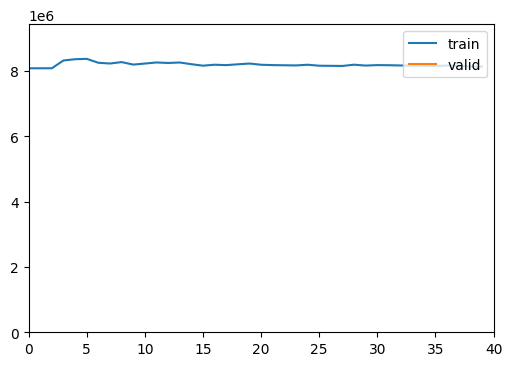

epoch,train_loss,valid_loss,time
0,8192969.000000,9421308.000000,00:21
1,8174307.500000,9426721.000000,00:21
2,8156087.500000,9444631.000000,00:21
3,8136625.000000,9440114.000000,00:21
4,8131771.000000,9448573.000000,00:21
5,8128379.500000,9427656.000000,00:21
6,8139591.000000,9441234.000000,00:21
7,8153581.000000,9483178.000000,00:21
8,8135799.000000,9481745.000000,00:21
9,8144029.500000,9486009.000000,00:21


Better model found at epoch 0 with valid_loss value: 9421308.0.


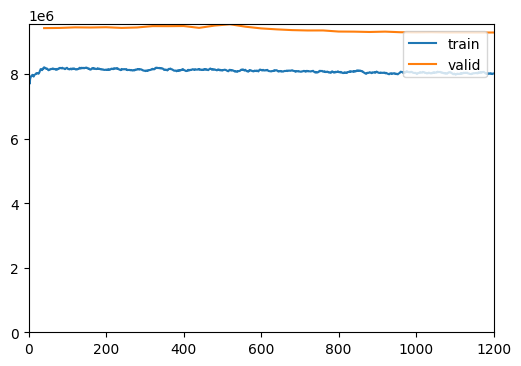

Epoch 1: reducing lr to 1.4567507511724669e-05
Epoch 2: reducing lr to 1.9849232884202e-05
Epoch 3: reducing lr to 2.6355287403487125e-05
Epoch 4: reducing lr to 3.330095146055419e-05
Epoch 5: reducing lr to 3.98484702604235e-05
Epoch 6: reducing lr to 4.520811833910915e-05
Epoch 7: reducing lr to 4.873344442617071e-05
Epoch 8: reducing lr to 4.999923847362972e-05
Epoch 9: reducing lr to 4.9734535837584077e-05
Epoch 10: reducing lr to 4.89167235096857e-05
Epoch 11: reducing lr to 4.7564656496014554e-05
Epoch 12: reducing lr to 4.570853815814416e-05
Epoch 13: reducing lr to 4.338983093727892e-05
Better model found at epoch 14 with valid_loss value: 9412427.0.
Better model found at epoch 15 with valid_loss value: 9382590.0.
Better model found at epoch 16 with valid_loss value: 9359296.0.
Better model found at epoch 17 with valid_loss value: 9347954.0.
Epoch 18: reducing lr to 2.696170824510821e-05
Better model found at epoch 19 with valid_loss value: 9314812.0.
Better model found at epoc

In [49]:
learn.fine_tune(30,base_lr=1e-3)

In [50]:
dls = db.dataloaders(df,bs=4)

In [51]:
learn.dls=dls

In [52]:
preds,gt = learn.get_preds()

/home/joheras/.conda/envs/python38/lib/python3.8/site-packages/torch/_tensor.py:1279: UserWarning: Using a target size (torch.Size([4, 1])) that is different to the input size (torch.Size([4])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  ret = func(*args, **kwargs)


In [53]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [54]:
gt[-1]

tensor([ 2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,
         2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,  2.4077,
        11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500,
        11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500, 11.3500,
         1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,
         1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,  1.7521,
         7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,
         7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500,  7.9500])

In [55]:
preds[-1]

TensorBase([[ 0.2091],
            [ 0.2135],
            [ 0.2222],
            [ 0.4353],
            [-0.0498],
            [ 0.1870],
            [-0.2538],
            [ 0.4242],
            [-0.6843],
            [-0.2919],
            [ 0.1418],
            [-0.6735],
            [-0.5533],
            [-0.2374],
            [-0.4162],
            [-0.0527],
            [ 0.4158],
            [ 0.5191],
            [ 0.7269],
            [ 0.4711],
            [-0.8042],
            [-0.4003],
            [-0.1956],
            [-0.4175],
            [-0.4462],
            [-0.2057],
            [-0.1997],
            [-0.4038],
            [ 0.4015],
            [-0.2200],
            [ 0.0491],
            [ 0.0322],
            [ 0.3776],
            [ 0.8699],
            [ 0.1641],
            [ 0.0310],
            [ 0.1306],
            [ 0.1321],
            [ 0.0234],
            [-0.3304],
            [-0.6036],
            [ 0.1601],
            [ 0.5032],
           

In [56]:
mean_absolute_error(gt[-1],preds[-1])

5.8854

In [57]:
mean_squared_error(gt[-1],preds[-1])

50.845436

In [58]:
math.sqrt(mean_squared_error(gt[-1],preds[-1]))

7.130598579094984